# Advanced Lane Line Finding
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Contents of the Submission
---
The submission containes the following files and folders.
1. README.md
2. xyz

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points
---
Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  


## Writeup / README
---

* Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it! Instead of writing a separate readme, I include everything relevant into this jupyter notebook. This reduces effort & redundancy.


## Camera Calibration
---

### Find Chessboard Corners

* Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in `./camCal.py`, function `findCorners()`, and was derived from `./examples/example.ipynb`.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

In [1]:
import numpy as np
import glob
import cv2
from camCal import findCorners

# Make a list of calibration images
imageFiles = sorted(glob.glob('./camera_cal/calibration*.jpg'))

imggen = (cv2.imread(fn) for fn in imageFiles)

objpoints, imgpoints, images = findCorners(imggen)


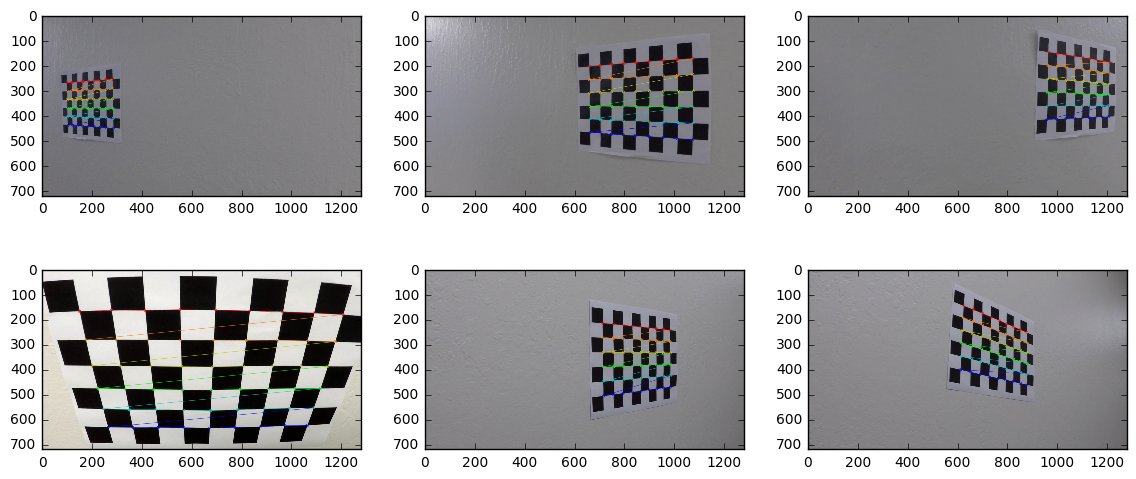

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# show samples
I=(1, 2, 4, 10, 15, 16)
plt.figure(figsize=(14,6))
for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.imshow(images[I[i]])
#plt.subplot(2, 3, 2)
#plt.imshow(images[4])
#plt.subplot(2, 3, 3)
#plt.imshow(images[10])
#plt.subplot(2, 3, 4)
#plt.imshow(images[15])
#plt.subplot(2, 3, 5)
#plt.imshow(images[1])
#plt.subplot(2, 3, 6)
#plt.imshow(images[16])


### Camera Calibration and Distortion Coefficients
I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained the following result.

The code for this step is contained in ./camCal.py, functions camCal() and undistortImg().


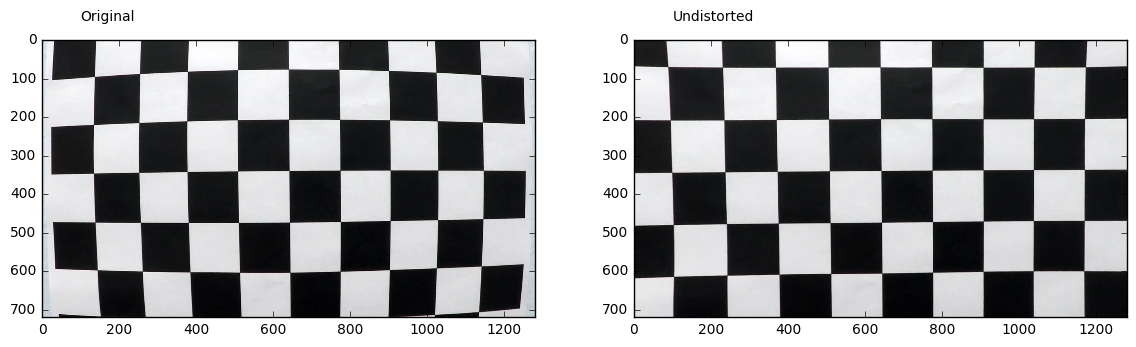

In [3]:
from camCal import camCal, undistortImg
%matplotlib inline

img=images[0]
shape=img.shape[::-1][1:]
mtx, dist, rvecs, tvecs=camCal(objpoints, imgpoints, shape)

image=cv2.imread('./camera_cal/calibration1.jpg')

# show samples
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.text(100, -50, 'Original')
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.text(100, -50, 'Undistorted')
plt.imshow(undistortImg(image, mtx, dist))



## Pipeline (test-images)
---
Read in all files from test_images folder

In [4]:
import numpy as np
import glob
import cv2
from camCal import findCorners

# Make a list of calibration images
testImageFiles = sorted(glob.glob('./test_images/*.jpg'))

testImages = [cv2.imread(fn) for fn in testImageFiles]


### Distortion Correction
- Provide an example of a distortion-corrected image.

In the following, I apply distortion correction to all sample images provided in the test_images folder. Finally I show three samples.

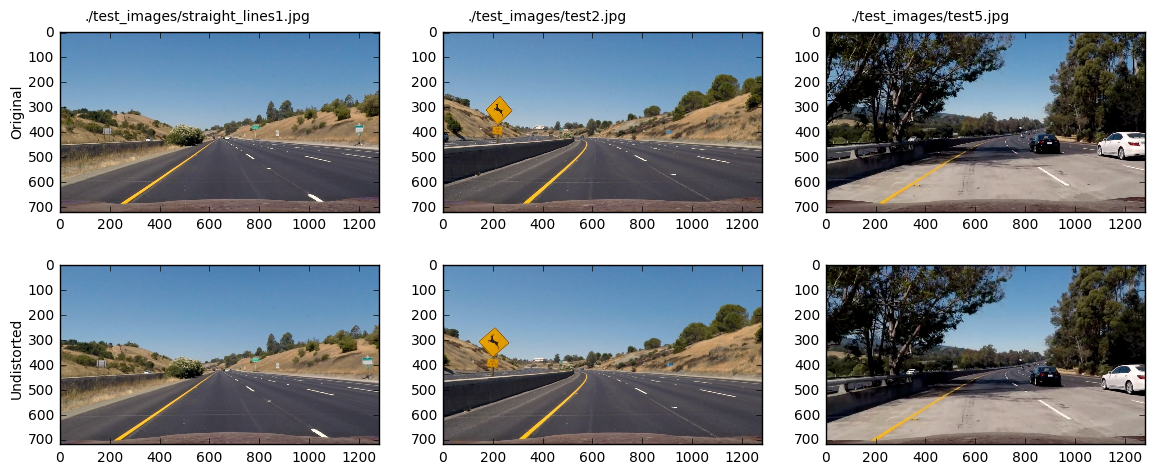

In [5]:
from helpers import bgr_rgb

undistTestImages=[undistortImg(img, mtx, dist) for img in testImages];

# show samples
plt.figure(figsize=(14,5.5))
I=(0, 3, 6)
plt.subplot(2, 3, 1)
plt.text(-200, 250, 'Original', rotation=90)
plt.subplot(2, 3, 4)
plt.text(-200, 250, 'Undistorted', rotation=90)
for i in range(0,3):
    plt.subplot(2, 3, i+1)
    
    plt.imshow(bgr_rgb(testImages[I[i]]))
    plt.text(100, -50, testImageFiles[I[i]])

    plt.subplot(2, 3, i+4)
    plt.imshow(bgr_rgb(undistTestImages[I[i]]))


### Creating a Thresholded Binary Image
- Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

#### Gradients
Computing the gradient in x or y direction does not account for the diagonal directions of the left/right lanes. Therefore I define the directed gradient, which computes the gradient in direction of the angle alpha.

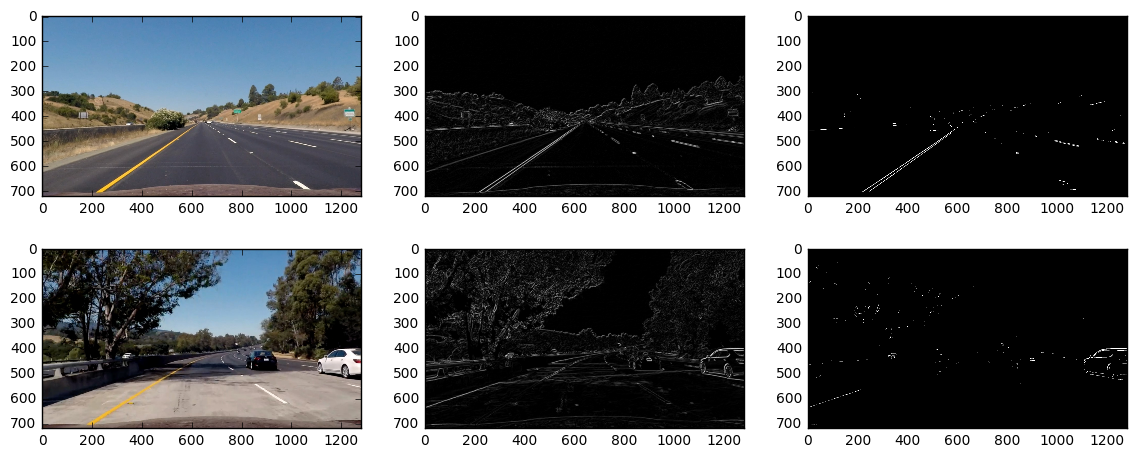

In [6]:
from helpers import bgr_gray
from binaryTransform import dir_sobel_thresh

# show samples
I=(0, 6)
plt.figure(figsize=(14,5.5))
for i in (0,1):
    plt.subplot(2, 3, 1+i*3)
    plt.imshow(bgr_rgb(undistTestImages[I[i]]))
    b, s=dir_sobel_thresh(bgr_gray(undistTestImages[I[i]]), sobel_kernel=7, alpha=np.arctan(400/300), thresh=(125, 255))
    plt.subplot(2, 3, 2+i*3)
    plt.imshow(s, cmap='gray')
    plt.subplot(2, 3, 3+i*3)
    plt.imshow(b, cmap='gray')

In the first row we can clearly see that the left lane is nicely identified. The gradient is computed in the direction $\alpha=\arctan(400/300)$, where $400/300$ is the approximate slope of the left lane. The right lane can be identified by applying the angle $\alpha=\arctan(-400/300)$. However, we see poor performance in the second row due to poor contrast. Therefore I want to try color space transforms. But first, some more examples applying 'magnitude of the gradient' and 'direction of the gradient'.

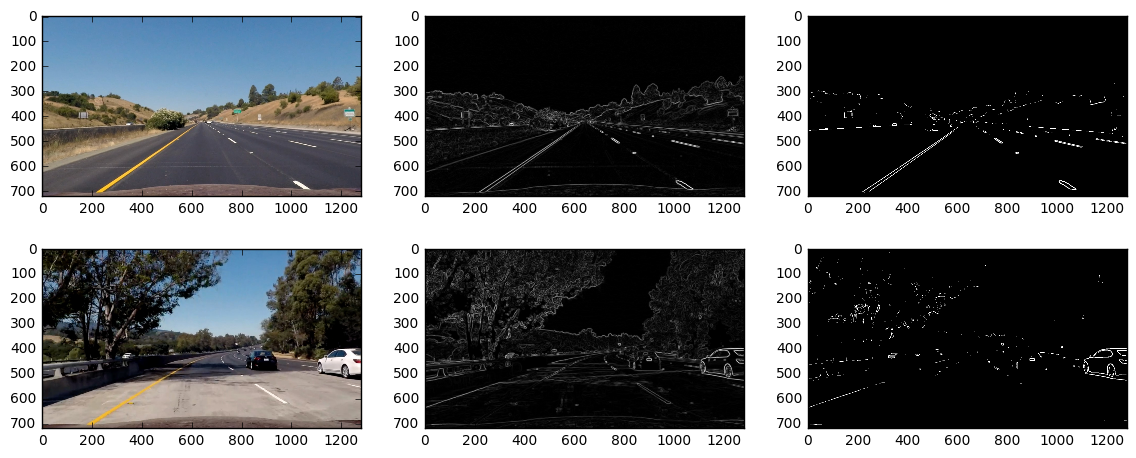

In [7]:
from helpers import bgr_gray
from binaryTransform import mag_thresh

# show samples
I=(0, 6)
plt.figure(figsize=(14,5.5))
for i in (0,1):
    plt.subplot(2, 3, 1+i*3)
    plt.imshow(bgr_rgb(undistTestImages[I[i]]))
    b, s=mag_thresh(bgr_gray(undistTestImages[I[i]]), sobel_kernel=7, thresh=(100, 255))
    plt.subplot(2, 3, 2+i*3)
    plt.imshow(s, cmap='gray')
    plt.subplot(2, 3, 3+i*3)
    plt.imshow(b, cmap='gray')

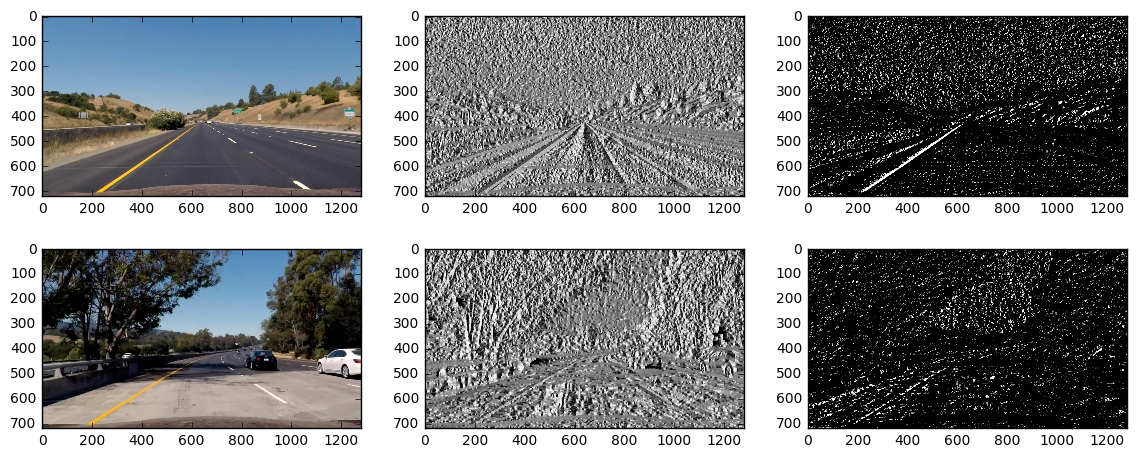

In [8]:
from helpers import bgr_gray
from binaryTransform import dir_threshold

# show samples
I=(0, 6)
plt.figure(figsize=(14,5.5))
for i in (0,1):
    plt.subplot(2, 3, 1+i*3)
    plt.imshow(bgr_rgb(undistTestImages[I[i]]))
    b, s=dir_threshold(bgr_gray(undistTestImages[I[i]]), sobel_kernel=15, thresh=(0.9*np.arctan(420/300), 1.1*np.arctan(420/200)))
    plt.subplot(2, 3, 2+i*3)
    plt.imshow(s, cmap='gray')
    plt.subplot(2, 3, 3+i*3)
    plt.imshow(b, cmap='gray')

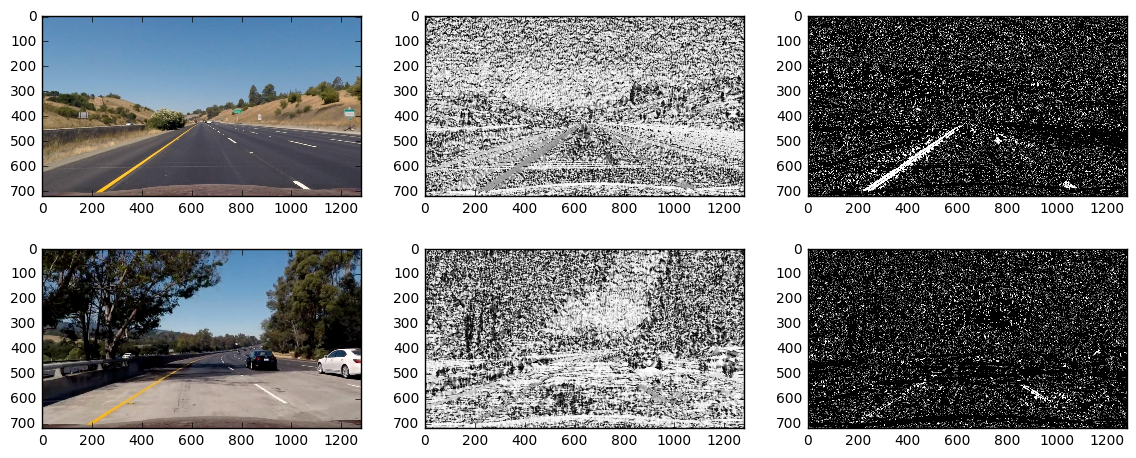

In [9]:
from helpers import bgr_gray
from binaryTransform import dirabs_threshold

# show samples
I=(0, 6)
plt.figure(figsize=(14,5.5))
for i in (0,1):
    plt.subplot(2, 3, 1+i*3)
    plt.imshow(bgr_rgb(undistTestImages[I[i]]))
    b, s=dirabs_threshold(bgr_gray(undistTestImages[I[i]]),  sobel_kernel=25, thresh=(0.9, 1.1))
    plt.subplot(2, 3, 2+i*3)
    plt.imshow(s, cmap='gray')
    plt.subplot(2, 3, 3+i*3)
    plt.imshow(b, cmap='gray')

#### Color Space Transforms
As discussed in the course, by just transforming to gray scale, much information may be lost. Instead, here I use color space transfomations in order to preserve valuable information as value, saturation or lightness.